# English Text Summarization Final Project
**Begad Tamim - 211002177**

# Table of Contents

1. [Import the necessary libraries](#import-libraries)
2. [Data Reading and Preprocessing](#data-preprocessing)
3. [Understanding the distribution of the sequences](#distribution-sequences)
4. [Text and Summary Tokenization](#tokenization)
5. [Building the Model](#building-model)
6. [Training Plot Evaluation](#training-plot)
7. [Setting Up the Inference Model](#inference-model)


## Import the necessary libraries
<a id='import-libraries'></a>

In [129]:
import re 
import warnings
import numpy as np  
import pandas as pd 
import gradio as gr
import dill as pickle
import tensorflow as tf
from bs4 import BeautifulSoup 
from keras import backend as K 
import  matplotlib.pyplot as plt 
from nltk.corpus import stopwords   
from attention import AttentionLayer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional


pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [64]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Data Reading and Preprocessing
<a id='data-preprocessing'></a>

In [65]:
# load the data
data = pd.read_csv("Amazon Fine Food Reviews\Reviews.csv", nrows=50000)

# Drop Duplicates and NAs
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [66]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [67]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [68]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

# Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [69]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [70]:
# top 5 reviews and their summary
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo


## Understanding the distribution of the sequences
<a id='distribution-sequences'></a>

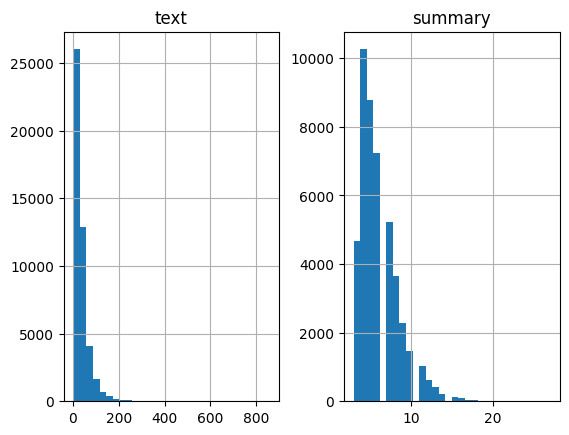

In [71]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [72]:
max_len_text=80 
max_len_summary=10

In [73]:
# Split dataset into a training and validation set
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

## Text and Summary Tokenization
<a id='tokenization'></a>

In [74]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [75]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

## Building the Model
<a id='building-model'></a>

In [76]:
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 500)   │ 18,339,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 80, 500), │  2,002,000 │ embedding[0][0]   │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 80, 500), │  2,002,000 │ lstm[0][0]        │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 500) │  5,028,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 80, 500), │  2,002,000 │ lstm_1[0][0]      │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  2,002,000 │ embedding_1[0][0… │
│                     │ 500), (None,      │            │ lstm_2[0][1],     │
│                     │ 500), (None,      │            │ lstm_2[0][2]      │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    500,500 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 500), (None,      │            │ lstm_3[0][0]      │
│                     │ None, 80)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None,      │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │ 1000)             │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 10,067,057 │ concat_layer[0][… │
│ (TimeDistributed)   │ 10057)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,943,057 (160.00 MB)

 Trainable params: 41,943,057 (160.00 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# stop training the neural network at the right time by monitoring a user-specified metric
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [78]:
# train the model on a batch size of 512 and validate it on the holdout set
history = model.fit(
    [x_tr, y_tr[:, :-1]], 
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], 
    epochs=5,
    callbacks=[es],
    batch_size=512, 
    validation_data=(
        [x_val, y_val[:, :-1]], 
        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]
    )
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 857s 10s/step - accuracy: 0.4419 - loss: 4.7261 - val_accuracy: 0.5943 - val_loss: 2.9816
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 804s 10s/step - accuracy: 0.5838 - loss: 3.0668 - val_accuracy: 0.5943 - val_loss: 2.9497
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 921s 11s/step - accuracy: 0.5841 - loss: 3.0284 - val_accuracy: 0.5937 - val_loss: 2.9136
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1074s 13s/step - accuracy: 0.5854 - loss: 3.0045 - val_accuracy: 0.5877 - val_loss: 2.9035
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 817s 10s/step - accuracy: 0.5847 - loss: 2.9885 - val_accuracy: 0.5939 - val_loss: 2.8730


In [ ]:
pickle.dump_session('model.pkl')

In [ ]:
pickle.load_session("model.pkl")

## Training Plot Evaluation
<a id='training-plot'></a>

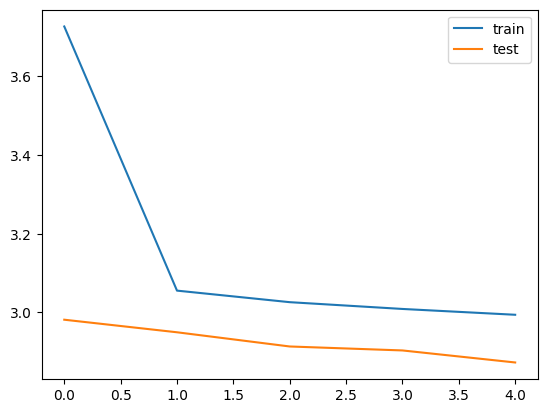

In [118]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

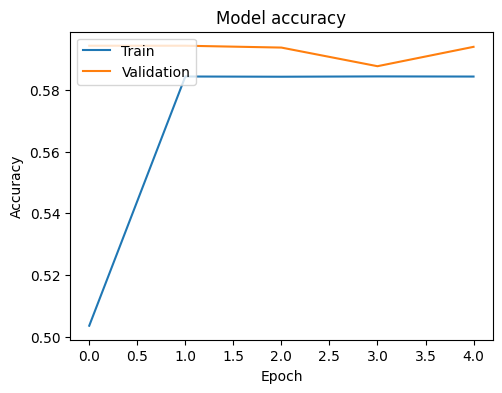

In [119]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

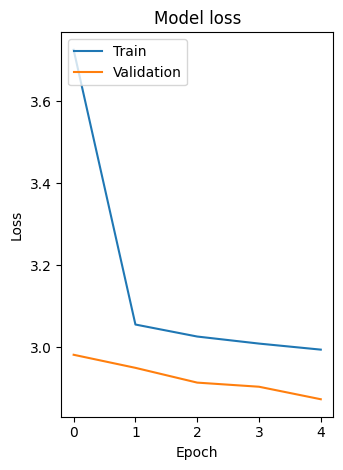

In [120]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Setting Up the Inference Model
<a id='inference-model'></a>

In [121]:
# convert the index to word for target and source vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [122]:
reverse_target_word_index[0] = ''

In [123]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)


In [124]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = y_tokenizer.word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = y_tokenizer.index_word[sampled_token_index]

        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'end' or len(decoded_sentence.split()) >= max_len_summary-1:
            stop_condition = True
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence.strip()

In [125]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if ((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString.strip()

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '
    return newString.strip()

In [130]:
iface = gr.Interface(
    fn=summary_cleaner,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.Textbox()
)

iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7870

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
